## Visualizations<br>
catalog:<br>
1. Forecast based visuals
2. Past returns vs. Future expected
3. Return vs volatility
4. Best and worst buys (bar Chart) of returns ( top 10 / bottom 10)
5. Technical Analysis - line chart SMA50 / SMA200 by symbol ( add buy /sell signals)
6. Technical Analysis - buy/sell/hold by stock 

In [3]:
import cml.data_v1 as cmldata
import os
import json, requests
from joblib import dump, load

import matplotlib as mlab
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import math
import pandas as pd
import numpy as np

In [4]:
CONNECTION_NAME = "loki-rtdm"
# ## Sample Usage to get pandas data frame
EXAMPLE_SQL_QUERY = "show databases"
# Alternate Sample Usage to provide different credentials as optional parameters
conn = cmldata.get_connection(
   CONNECTION_NAME, {"USERNAME": os.environ['PROJECT_OWNER'], "PASSWORD": "D83j8TNG#PS#jAQ"}
)

**Get Data**

In [5]:
get_sample_data = "select * from loki_stocks.stock_history \
where symbol_time > '2022-12-18'"
df = conn.get_pandas_dataframe(get_sample_data)

df.drop(['last_refreshed','information'],axis=1,inplace=True)

In [6]:
# symbol of top 10 tickers with most observations
tck_keep_list = df.groupby('symbol').size().sort_values().tail(10).reset_index().symbol.tolist()
# create a df with last 100 time stamps
df_light = df[df.symbol.isin(tck_keep_list)].copy()

window_begin = df_light.symbol_time.drop_duplicates().sort_values().tail(100).min()

df_light = df_light[df_light.symbol_time >= window_begin].copy()
df_light.shape

(660, 7)

In [7]:
df_light.symbol.unique()

array(['SYF', 'GOOGL', 'AMZN', 'HWM', 'TSLA', 'NVDA', 'KEY', 'MOS',
       'SWKS'], dtype=object)

In [9]:
# df_light.tail()

#### Forecast Visual
hit model with all stocks

In [10]:
model_url = 'https://modelservice.ml-92202c44-d46.loki-cdp.a465-9q4k.cloudera.site/model'
accessKey = 'm45a083on9okf24psw58d0v8j6ht6w3u'

In [11]:
cols = ['symbol', 'symbol_time','close', 'volume']

In [12]:
input_data_mult = dict()
for col in cols:
    input_data_mult[col] = df_light[col].to_list()    
    
# build embedded dictionary step 1    
request_dict = {"request":input_data_mult}

# access key will be end point specific
BackDict = {"accessKey":accessKey}
BackDict.update(request_dict)
request_dict=BackDict

In [13]:
%%time
r = requests.post(model_url, data=json.dumps(request_dict),headers={'Content-Type': 'application/json'})

CPU times: user 9.18 ms, sys: 3.74 ms, total: 12.9 ms
Wall time: 163 ms


In [14]:
response = r.json()['response']['prediction']

In [15]:
test_df = pd.DataFrame.from_dict(response)

In [16]:
test_df.head()

,pred_time,prediction,symbol
0,2022-12-22 20:00:00,"[32.3353157043457, 32.33622360229492, 32.33319...",SYF
1,2022-12-22 20:00:00,"[87.56707763671875, 87.5639419555664, 87.55883...",GOOGL
2,2022-12-22 20:00:00,"[83.3201675415039, 83.31318664550781, 83.30554...",AMZN
3,2022-12-22 20:00:00,"[38.53777313232422, 38.538307189941406, 38.534...",HWM
4,2022-12-22 20:00:00,"[126.91903686523438, 126.89751434326172, 126.8...",TSLA


In [17]:
column_list = []
for i in range(1,13):
    col = 'f_'+str(i)
    column_list.append(col)
    
pred_df = pd.DataFrame(columns=column_list)
for i in range(len(test_df)):
    pred_df.loc[i] = test_df.iloc[i,1]

In [18]:
pred_df.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12
0,32.335316,32.336224,32.333191,32.337585,32.329288,32.336529,32.335209,32.331589,32.345909,32.342384,32.343513,32.342545
1,87.567078,87.563942,87.558830,87.571220,87.551086,87.565216,87.556641,87.551117,87.576363,87.566795,87.564148,87.565453
2,83.320168,83.313187,83.305542,83.315308,83.292313,83.301811,83.290047,83.283310,83.301376,83.291756,83.286354,83.285835
3,38.537773,38.538307,38.534782,38.540215,38.531067,38.539101,38.537384,38.533398,38.549934,38.545940,38.546986,38.546383
4,126.919037,126.897514,126.870552,126.899818,126.846985,126.822144,126.831146,126.782318,126.806648,126.785934,126.796211,126.791107


In [19]:
df_out = pd.concat([test_df,pred_df],axis=1).drop(['prediction'],axis=1)

In [20]:
# we need to add most recent price from history to df
last_price = []
for i,tckr in enumerate(df_light.symbol.unique()):
    temp = df_light[df_light.symbol == tckr].copy()
    temp = temp.sort_values('symbol_time').tail(1)
    #print('symbol ',tckr,'date ',temp.symbol_time.values[0],' close price ', temp.close.values[0])
    last_price.append(temp.close.values[0])

In [21]:
df_out['f_0'] = last_price

In [23]:
# need to reorder the columns
df_out = df_out[['pred_time', 'symbol', 'f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12']]

In [24]:
# create a return list
column_return_list = []
for i in range(1,13):
    col = 'ret_'+str(i)
    column_return_list.append(col)
# create an independent return df, will be concatenated with main df down below
return_df = pd.DataFrame(columns=column_return_list)
for i in range(len(df_out)):
    return_df.loc[i] = (df_out.loc[i][2:].pct_change()[1:].cumsum().apply(np.exp)*100).tolist()   

In [25]:
df_out2 = pd.concat([df_out,return_df],axis=1)

In [26]:
# all signals
# plt.figure(num = 3, figsize=(8, 5))
# x = range(1,13)
# for i in range(len(df_out)):
#     y = df_out2.loc[i][-12:].tolist()
#     plt.plot(x, y)
# plt.show()

# Viz 1
prospective - forecast model based

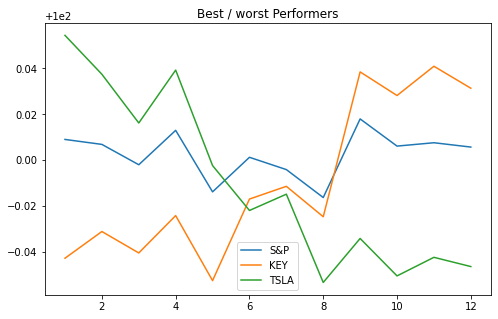

In [27]:
plt.figure(num = 3, figsize=(8, 5))
x = range(1,13)
# S&P 
y = df_out2.iloc[:,-12:].mean()
plt.plot(x, y,label='S&P')
# best
y = df_out2[df_out2.ret_12 == df_out2.ret_12.max()].iloc[:,-12:].values[0].tolist()
best_stock = df_out2[df_out2.ret_12 == df_out2.ret_12.max()].iloc[:,1].values[0]
plt.plot(x, y,label=best_stock)
# worst
y = df_out2[df_out2.ret_12 == df_out2.ret_12.min()].iloc[:,-12:].values[0].tolist()
worst_stock = df_out2[df_out2.ret_12 == df_out2.ret_12.min()].iloc[:,1].values[0]
plt.plot(x, y,label = worst_stock)
plt.legend()
plt.title('Best / worst Performers')
plt.show()

**Start of viz2**

In [28]:
df_light.groupby(['symbol']).size()

symbol
AMZN     100
GOOGL     93
HWM       54
KEY       53
MOS       54
NVDA      99
SWKS      53
SYF       54
TSLA     100
dtype: int64

In [31]:
import warnings
warnings.filterwarnings('ignore')
from transform_forecaster import fill_blanks;

In [32]:
date_range = df_light.symbol_time.drop_duplicates()
date_range = pd.DataFrame(date_range)

In [40]:
stock_ready = fill_blanks(df_light,'symbol',date_range,'symbol_time')

In [41]:
stock_ready = stock_ready[['symbol', 'symbol_time', 'close', 'volume']]

In [42]:
stock_ready.columns

Index(['symbol', 'symbol_time', 'close', 'volume'], dtype='object')

In [47]:
df_int = pd.DataFrame()
for tckr in stock_ready.symbol.unique():
    temp = stock_ready[stock_ready["symbol"] == tckr]
    temp.sort_values('symbol_time', inplace=True)
    temp['return'] = np.log(temp.close / temp.close.shift(1))  
    temp.dropna(inplace=True)
    temp['performance'] = temp['return'].cumsum().apply(np.exp)
    temp = temp.sort_values('symbol_time').tail(1)
    df_int = df_int.append(temp,ignore_index=True)

,symbol,symbol_time,close,volume,return,performance
0,SYF,2022-12-22 20:00:00,32.099998,56089.0,0.000000,1.000000
1,GOOGL,2022-12-22 20:00:00,87.550003,2675.0,-0.000571,1.004108
2,AMZN,2022-12-22 20:00:00,83.300003,13983.0,-0.000240,0.996471
3,HWM,2022-12-22 20:00:00,38.349998,10717.0,0.000000,1.000000
4,TSLA,2022-12-22 20:00:00,126.849998,151616.0,-0.006678,0.986776
5,NVDA,2022-12-22 20:00:00,151.660004,5267.0,-0.002897,0.999755
6,KEY,2022-12-22 20:00:00,16.820000,98576.0,0.000000,1.000000
7,MOS,2022-12-22 20:00:00,44.459999,35155.0,0.000000,1.000000
8,SWKS,2022-12-22 20:00:00,87.220001,24845.0,0.000000,1.000000


In [67]:
df1 = df_int[['symbol','performance','volume']]
df2 = df_out2[['symbol','ret_12']]

In [68]:
# get last date for this ... performance
df_scatter = df1.merge(df2,how='left',on='symbol')

In [70]:
df_scatter['performance'] = df_scatter['performance']*100
#df_scatter['ret_12'] = df_scatter['ret_12'] -1
df_scatter

,symbol,performance,volume,ret_12
0,SYF,100.000000,56089.0,100.007887
1,GOOGL,100.410819,2675.0,100.017659
2,AMZN,99.647110,13983.0,99.983005
3,HWM,100.000000,10717.0,100.016576
4,TSLA,98.677554,151616.0,99.953617
5,NVDA,99.975477,5267.0,100.028168
6,KEY,100.000000,98576.0,100.031387
7,MOS,100.000000,35155.0,100.017106
8,SWKS,100.000000,24845.0,99.996090


# Viz 2

<AxesSubplot:xlabel='performance', ylabel='ret_12'>

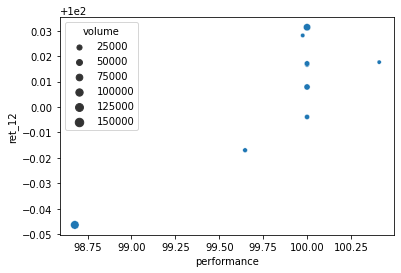

In [71]:
sns.scatterplot(data=df_scatter, x="performance", y="ret_12",size="volume")